# Content-Based Recommendation System for Movies

With the increasing popularity of online streaming platforms, users are exposed to thousands of movies across various genres and categories. Finding relevant content has become both time-consuming and inefficient without intelligent filtering mechanisms. Recommendation systems powered by artificial intelligence have emerged as a practical solution to this challenge.

This project implements a Content-Based Movie Recommendation System that leverages machine learning and natural language processing techniques to analyze movie metadata and descriptions. The system learns user preferences from previously liked or watched movies and recommends similar movies that align with the user’s interests. This personalized approach improves user satisfaction and enhances the overall content discovery experience.

## Libraries and Data Loading

In [57]:
#Loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import joblib
import itertools
import random
from scipy.sparse import hstack
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from collections import Counter
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, normalize

In [2]:
#Loading our dataset

movies = pd.read_csv('../data/tmdb_5000_movies.csv')
credits = pd.read_csv('../data/tmdb_5000_credits.csv')

In [3]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Data preprocessing

In [5]:
#Some info about the datasets

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [6]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [7]:
#Merge these two datasets

data = movies.merge(
    credits, 
    left_on='id',
    right_on='movie_id',
    how='outer'
)

data.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,4000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 35, ""name...",NaN,5,"[{""id"": 612, ""name"": ""hotel""}, {""id"": 613, ""na...",en,Four Rooms,It's Ted the Bellhop's first night on the job....,22.87623,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,530,5,Four Rooms,"[{""cast_id"": 42, ""character"": ""Ted the Bellhop...","[{""credit_id"": ""52fe420dc3a36847f800012d"", ""de..."


In [8]:
#Check if id and movie_id columns are the same

(data['id'] == data['movie_id']).all()

np.True_

In [9]:
#Delete one of the columns mentioned above
#Leaving one column in case of further data merging

data_cleaning = data.drop(['id'], axis=1)

In [10]:
#Check NaN values in columns

data_cleaning.isnull().sum()

budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
movie_id                   0
title_y                    0
cast                       0
crew                       0
dtype: int64

In [11]:
#Homepage column is unnecessary and there are too many NaN values to keep it

data_cleaning.drop(['homepage'], axis=1, inplace=True)

In [12]:
#Tagline may be useful and NaN do not represent majority in the dataset,
# so missing values are replaced with an empty string

data_cleaning['tagline'] = data_cleaning['tagline'].fillna('')

In [13]:
#Remaining NaN represent a very small part of this column, so fill them with 'Unknown'

data_cleaning['overview'] = data_cleaning['overview'].fillna('Unknown')
data_cleaning['release_date'] = data_cleaning['release_date'].fillna('Unknown')
data_cleaning['runtime'] = data_cleaning['runtime'].fillna(0)

In [14]:
#Check if title_x and title_y are indentical
#if so, we will delete them and leave only original_title

print((data_cleaning['title_x'] == data_cleaning['title_y']).all())

data_cleaning.drop(['title_x', 'title_y'], axis=1, inplace=True)

True


In [15]:
#Some numerical values are indecipherable so let's convert them

data_cleaning['budget_formatted'] = data_cleaning['budget'].apply(lambda x: f"{x:,}")

data_cleaning['revenue_formatted'] = data_cleaning['revenue'].apply(lambda x: f"{x:,}")

In [16]:
#We can now cut original pre-formatted coolumns

data_cleaning.drop(['budget', 'revenue'], axis=1, inplace=True)

In [17]:
#Extract year form release_date column. Movie release year may be useful in further research

data_cleaning['release_date'] = pd.to_datetime(data_cleaning['release_date'], errors='coerce')

data_cleaning['release_year'] = data_cleaning['release_date'].dt.year

data_cleaning['release_year'] = data_cleaning['release_year'].astype('Int64')

In [18]:
#Handling with json columns

data_after_json = data_cleaning.copy()

json_columns = [
    'genres',
    'keywords',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'cast',
    'crew'
]

In [19]:
def parse(x):
    try:
        if isinstance(x, list):
            return x
        if pd.isna(x) or x == '':
            return []
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

def get_list_names(x):
    if isinstance(x, list):
        return [i['name'] for i in x]
    return []

#limit numbers of actors to maximum 5 
def get_5_cast(x, n=5):
    if isinstance(x, list):
        return [i['name'] for i in x[:n]]
    return []
        
#Select only director
def get_boss(x):
    if isinstance(x, list):
        for i in x:
            if i['job'] == 'Director':
                return i['name'].replace(" ", " ")
    return ''

In [20]:
#Parse for every json column
for column in json_columns:
    data_after_json[column] = data_after_json[column].apply(parse)

#Crew and cast columns have to be separately (different functions)
for_all = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']

for column in for_all:
    data_after_json[column] = data_after_json[column].apply(get_list_names)


data_after_json['cast'] = data_after_json['cast'].apply(get_5_cast)


data_after_json['crew'] = data_after_json['crew'].apply(get_boss)
data_after_json.rename(columns={'crew': 'director'}, inplace=True)

At this point, all columns have been properly cleaned and are readable for both humans and computational processing, so we can proceed to the EDA section.

## Exploratory Data Analysis

### Section I - Dataset Overview & Data Quality

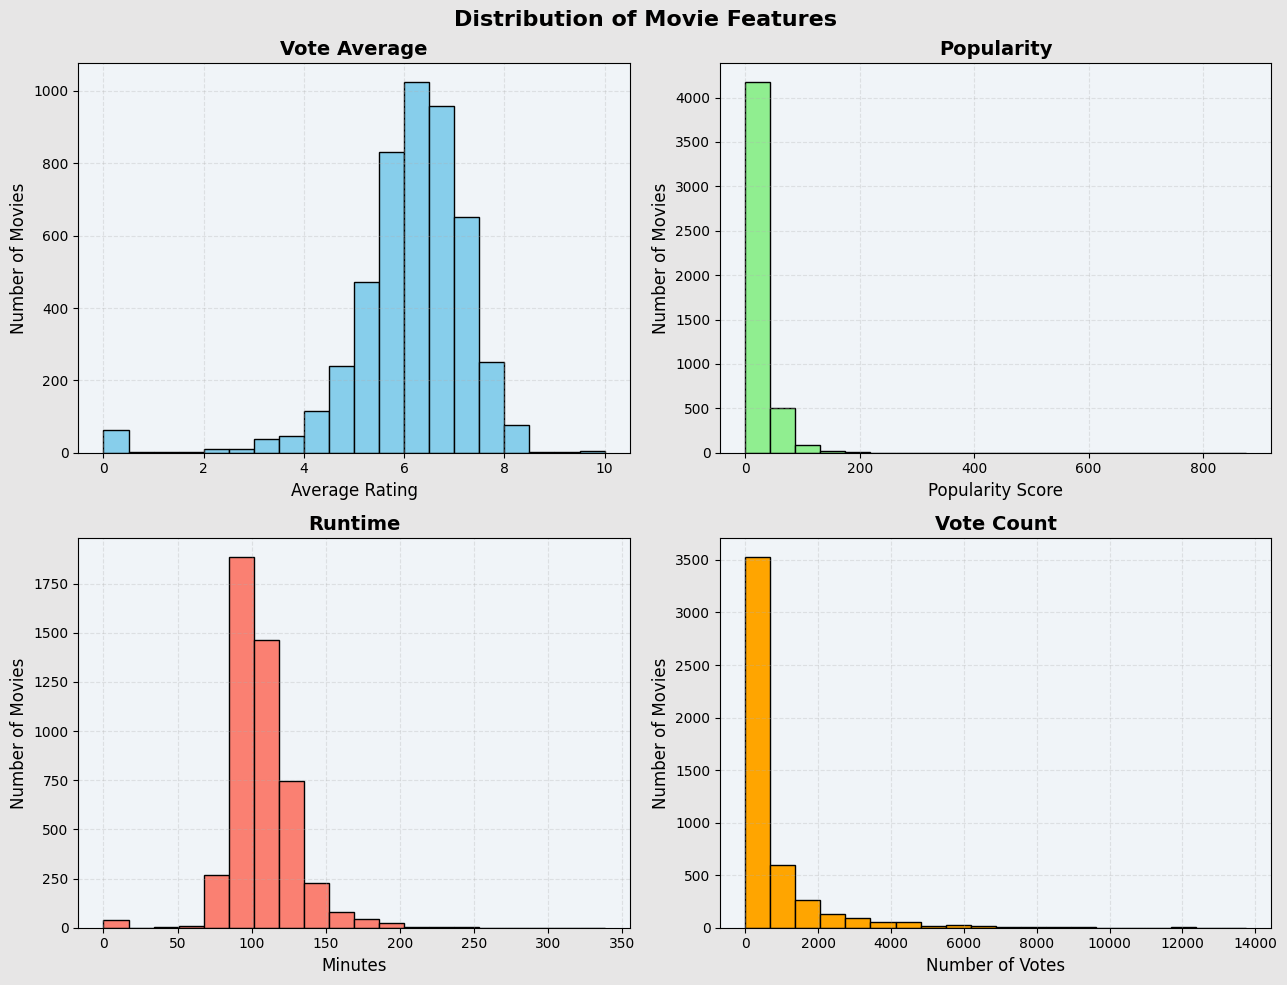

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10), facecolor="#e7e6e6") 
fig.suptitle('Distribution of Movie Features', fontsize=16, fontweight='bold')

# Vote Average
axes[0,0].hist(data_after_json['vote_average'], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('Vote Average', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Average Rating', fontsize=12)
axes[0,0].set_ylabel('Number of Movies', fontsize=12)
axes[0,0].set_facecolor("#f0f4f8")  
axes[0,0].grid(True, linestyle='--', alpha=0.3)

# Popularity
axes[0,1].hist(data_after_json['popularity'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Popularity', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Popularity Score', fontsize=12)
axes[0,1].set_ylabel('Number of Movies', fontsize=12)
axes[0,1].set_facecolor("#f0f4f8")
axes[0,1].grid(True, linestyle='--', alpha=0.3)

# Runtime
axes[1,0].hist(data_after_json['runtime'], bins=20, color='salmon', edgecolor='black')
axes[1,0].set_title('Runtime', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Minutes', fontsize=12)
axes[1,0].set_ylabel('Number of Movies', fontsize=12)
axes[1,0].set_facecolor("#f0f4f8")
axes[1,0].grid(True, linestyle='--', alpha=0.3)

# Vote Count
axes[1,1].hist(data_after_json['vote_count'], bins=20, color='orange', edgecolor='black')
axes[1,1].set_title('Vote Count', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Number of Votes', fontsize=12)
axes[1,1].set_ylabel('Number of Movies', fontsize=12)
axes[1,1].set_facecolor('#f0f4f8')
axes[1,1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout() 
plt.savefig('../images/Distribution_of_Movie_Features.png', dpi=300, bbox_inches='tight')
plt.show()

The four histograms show that there are no obvious outliers in the dataset, although some entries may require further investigation. No movies should be removed without carefully examining both the charts and the underlying data.

#### **Upper left: Vote Average**

The vote average histogram indicates that most movies have ratings between 2 and 8. Some movies have a 0 average score, which could reflect either very poor films or movies with very few ratings. Conversely, a few movies have an average rating of 10, which may indicate exceptionally good films or again very few ratings. It would be a good idea to review movies with 0 or 10 average ratings.

#### **Upper right: Popularity**

The popularity score histogram shows no major outliers. Most movies have scores between 0 and 40, while the overall range extends up to around 200. Movies with popularity scores above 200 may warrant further examination to verify their characteristics and consistency with other features.

#### **Bottom left: Runtime**

The runtime histogram shows that most films last between 50 and 200 minutes, with a clear peak around 90–120 minutes (approximately 1.5–2 hours). Some movies have runtimes of 0–15 minutes, which is clearly unrealistic, while a few films exceed 200 minutes (over 3 hours). Investigating or cleaning entries with 0-minute runtimes is recommended.

#### **Bottom right: Vote Count**

The vote count histogram indicates that most movies have between 0 and 6,000 votes. Some films exceed 6,000 votes, and a few even reach around 12,000 votes, which could be unusual or misleading. It will be useful to examine movies with more than 6,000 votes to determine whether they are genuinely popular or if the data contains errors.

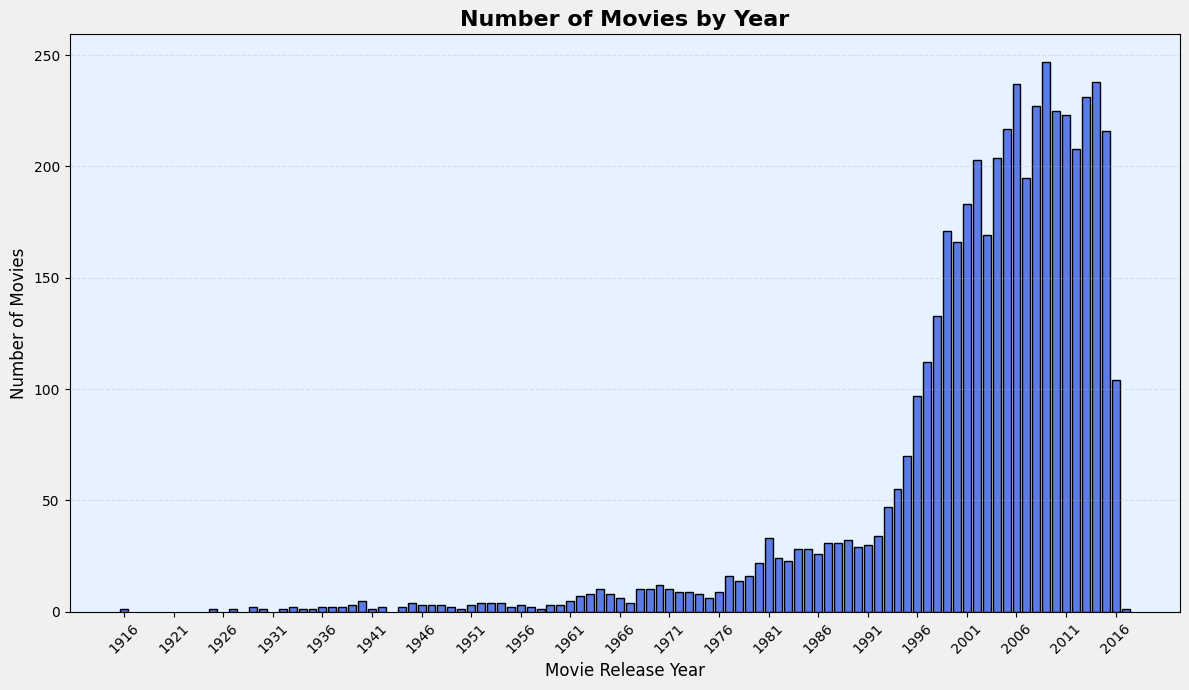

In [22]:
plt.figure(figsize=(12, 7), facecolor='#f0f0f0')  

years = data_after_json['release_year'].value_counts().sort_index()

bars = plt.bar(years.index, years.values, color='#5b7be6', edgecolor='black')

plt.xlabel('Movie Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Number of Movies by Year', fontsize=16, fontweight='bold')

plt.xticks(ticks=np.arange(min(years.index), max(years.index)+1, 5), 
           rotation=45, fontsize=10)

plt.gca().set_facecolor('#e6f2ff')  

# Siatka
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/Number_of_Movies_by_Year.png', dpi=300, bbox_inches='tight')
plt.show()


The chart above shows a clear domination of movies produced in the 21st century. There is a noticeable upward trend since the early 1990. Most films released after 2003 number between 200 and 250 per year, while films produced before 1993 range from just 1 to approximately 40 per year. There is a visible decline after 2016, which may be due to the dataset not including newly released films.

Consequently, older movies may be evaluated less favorably than newer ones. This imbalance should be carefully addressed in the modeling process.

### Section II - Genre Analysis

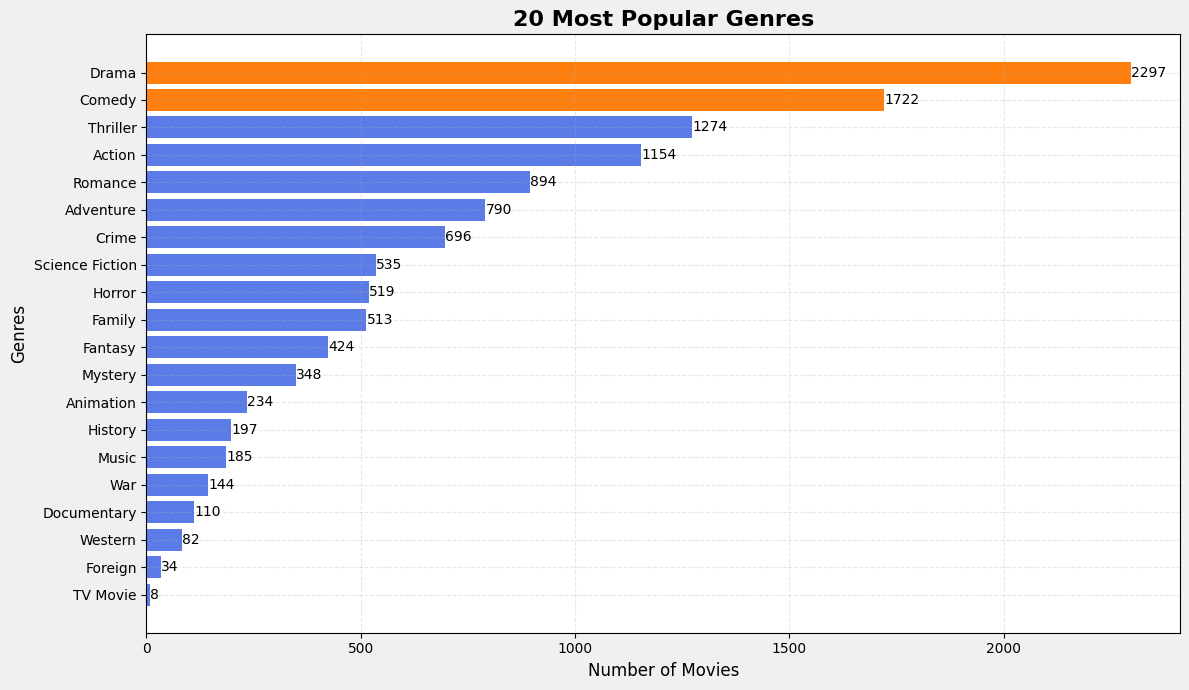

In [23]:
plt.figure(figsize=(12, 7), facecolor='#f0f0f0')

genre_counts = data_after_json['genres'].explode().value_counts().head(20)

colors = ['#ff7f0e' if i < 2 else '#5b7be6' for i in range(len(genre_counts))]

bars = plt.barh(genre_counts.index, genre_counts.values, color=colors)

for bar in bars:
    plt.text(bar.get_width() + 1,               
             bar.get_y() + bar.get_height()/2, 
             int(bar.get_width()),             
             va='center', fontsize=10)

plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.title('20 Most Popular Genres', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('../images/20_Most_Popular_Genres.png', dpi=300, bbox_inches='tight')
plt.show()


Drama (around 2,297 movies) and Comedy (around 1,722 movies) dominate the dataset, occupying the top two positions. Action and Thriller follow with approximately 1,154 and 1,274 movies, respectively. On the other hand, niche genres understandably have far fewer films, such as Westerns (about 82) and Foreign movies (around 34). These niche films may receive less accurate recommendations due to the smaller sample sizes.

These imbalances have important implications for the content-based recommendation model:

- Popularity bias: Movies in dominant genres (Drama, Comedy) are likely to appear more frequently in recommendations, simply because the model has more examples to learn from.

- Sparse data for niche genres: Films in less-represented genres (Western, Foreign) may receive less accurate or less diverse recommendations due to the limited number of samples.

- Potential weighting strategies: It may be useful to assign slightly higher weights or apply smoothing for features from underrepresented genres to prevent them from being overshadowed by the dominant genres.

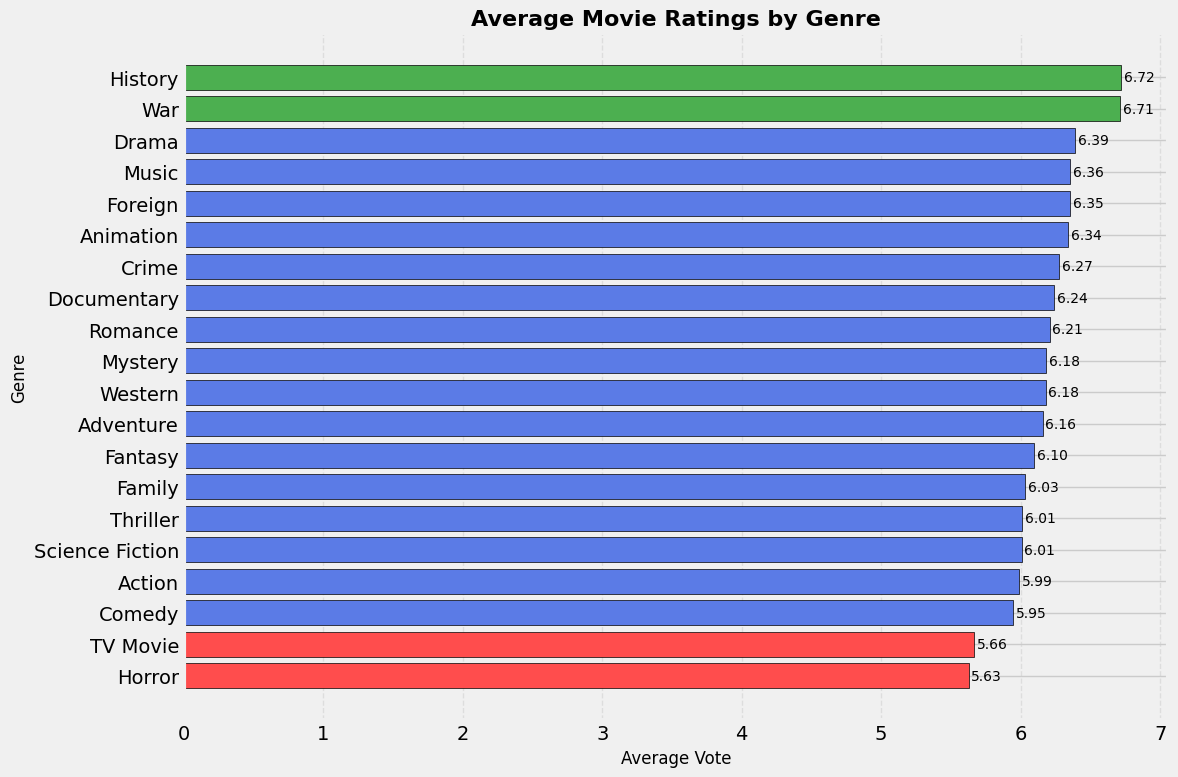

In [24]:
genre_avg = data_after_json.explode('genres').groupby('genres')['vote_average'].mean().sort_values(ascending=True)

plt.figure(figsize=(12,8), facecolor='#f0f0f0')
plt.style.use('fivethirtyeight') 

colors = ['#ff4d4d' if i < 2 else '#4caf50' if i >= len(genre_avg)-2 else '#5b7be6' 
          for i in range(len(genre_avg))]

bars = plt.barh(genre_avg.index, genre_avg.values, color=colors, edgecolor='black')

for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", 
             va='center', fontsize=10)

plt.xlabel('Average Vote', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.title('Average Movie Ratings by Genre', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().set_facecolor("#f0f0f0")

plt.tight_layout()
plt.savefig('../images/Average_Movie_Ratings_by_Genre.png', dpi=300, bbox_inches='tight')
plt.show()


The chart “Average Movie Ratings by Genre” shows that History and War movies occupy the top two positions, with average ratings of 6.72 and 6.71, respectively. These genres are not among the most numerous, as seen in the “20 Most Popular Genres” chart.

Drama, which ranks first in popularity, is also relatively highly rated with an average score of 6.39. In contrast, Comedy, which holds second place in popularity, is the third lowest-rated genre with an average rating of 5.95.

The two lowest-rated genres are TV Movie and Horror, with average ratings of 5.66 and 5.63, respectively.

From a modeling perspective, this indicates that popularity does not always correlate with rating quality. A content-based recommendation system could use this information to:

- Prioritize well-rated but less frequent genres (like History and War) for users seeking quality rather than mainstream popularity.

- Be cautious with popular but lower-rated genres (like Comedy), which may lead to less satisfying recommendations if relied on solely.

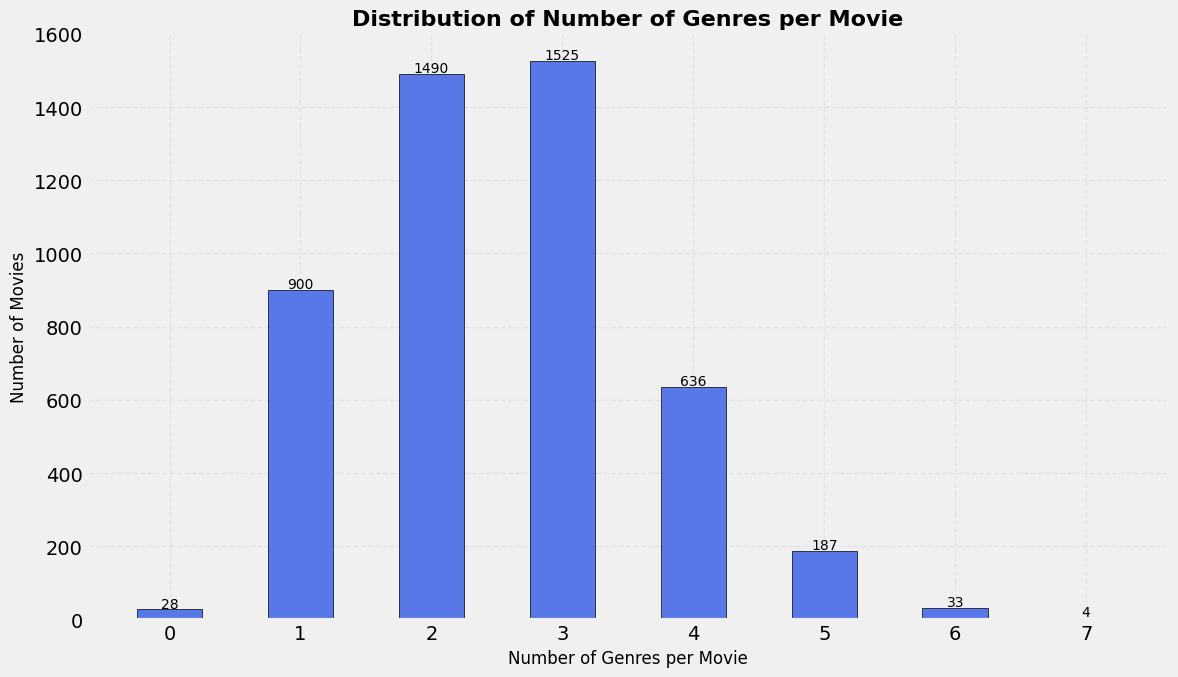

In [25]:
plt.figure(figsize=(12,7), facecolor='#f0f0f0')

data_after_json['num_genres'] = data_after_json['genres'].apply(len)
genre_dist = data_after_json['num_genres'].value_counts().sort_index()

bars = plt.bar(genre_dist.index, genre_dist.values,
               color="#5978e7", edgecolor='black', width=0.5)

plt.xlabel('Number of Genres per Movie', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Distribution of Number of Genres per Movie', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor("#f0f0f0")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+5,
             int(bar.get_height()), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../images/Distribution_of_Number_of_Genres_per_Movie.png', dpi=300, bbox_inches='tight')
plt.show()


As shown in the chart above, most movies belong to two or three genres, which together represent approximately 60% of all films in the dataset. Movies assigned to only one genre account for around 900 titles in the entire dataset.

There is a clear downward trend for movies with more than three genres. Only four movies are associated with seven genres, while 28 movies have no genre assigned at all. This may be due to missing information or the fact that some films could not be clearly classified into any specific genre.

From a modeling perspective, this distribution is beneficial for a content-based recommendation system. The presence of multiple genres per movie enriches feature representations and allows the model to better capture thematic similarities between films. Movies associated with two or three genres are more likely to be accurately matched with similar titles, while movies with only one or no genre may lead to less precise recommendations due to limited descriptive information.

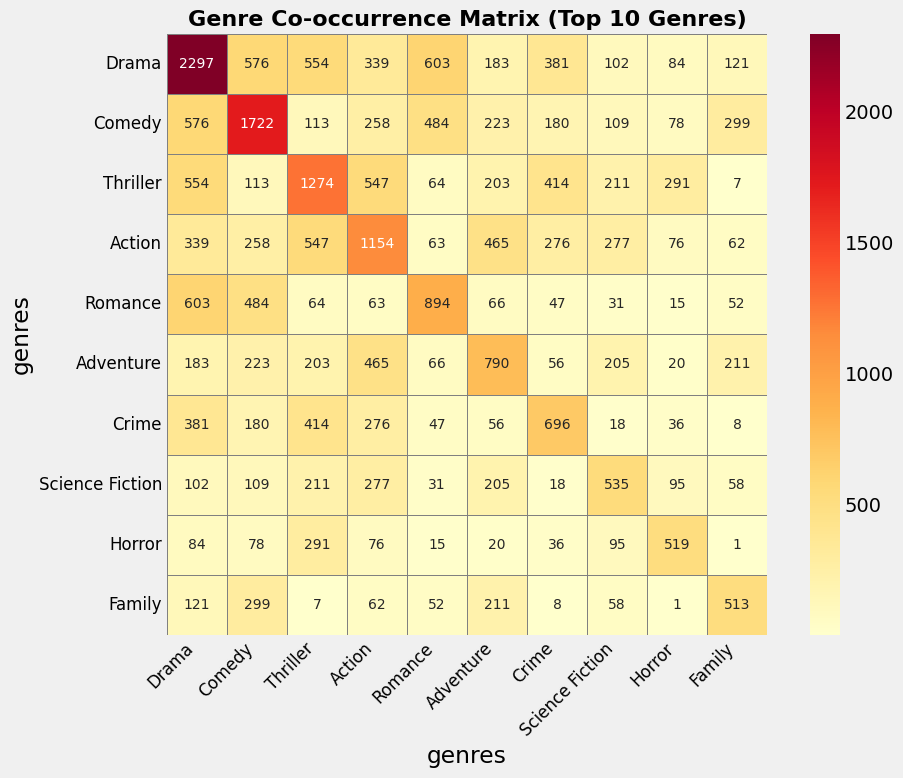

In [26]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(data_after_json['genres'])

co_occurrence = pd.DataFrame(genre_matrix.T @ genre_matrix, 
                             index=mlb.classes_, 
                             columns=mlb.classes_)

top_genres = data_after_json['genres'].explode().value_counts().head(10).index

plt.figure(figsize=(10, 8), facecolor='#f0f0f0')
sns.heatmap(co_occurrence.loc[top_genres, top_genres], 
            annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, linecolor='gray', cbar=True, square=True,
            annot_kws={"size":10})

plt.title('Genre Co-occurrence Matrix (Top 10 Genres)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('../images/Genre_Co-occurence_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap titled "Genre Co-occurrence Matrix (Top 10 Genres)" visualizes the co-occurrence frequency of the ten most common movie genres in the dataset. Both axes represent the same genres, including Drama, Comedy, Thriller, Action, etc. The color gradient encodes co-occurrence counts, ranging from pale yellow (low frequency) to deep red (high frequency), with diagonal values representing the total number of films belonging to each genre.

The diagonal values are the highest, reflecting self-occurrence: Drama appears in 2,297 films, and Comedy in 1,722. Off-diagonal entries quantify genre intersections, revealing prevalent combinations such as Drama–Comedy or Action–Thriller, which indicate how genres are commonly bundled in film production.

From a modeling perspective, this matrix highlights correlations between genres that a content-based recommendation system can exploit. High co-occurrence values suggest strong similarity signals between certain genres, which can be encoded as features to improve similarity scoring. Conversely, low-frequency pairings indicate sparser data, which may require smoothing or weighting strategies to avoid underrepresenting niche combinations in recommendations.

### Section III - Content Features Analysis

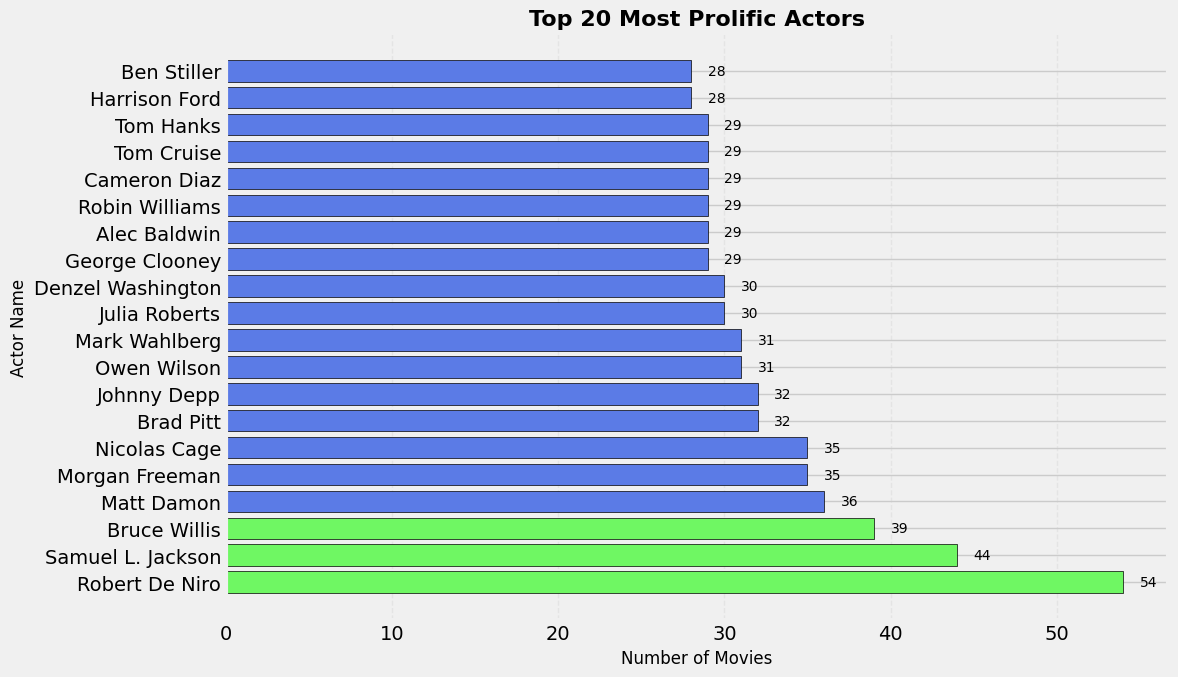

In [27]:
plt.figure(figsize=(12, 7), facecolor='#f0f0f0')

actor_counts = data_after_json['cast'].explode().value_counts().head(20)

colors = ["#6ff763" if i < 3 else '#5b7be6' if i >= len(actor_counts)-2 else '#5b7be6' 
          for i in range(len(actor_counts))]

bars = plt.barh(actor_counts.index, actor_counts.values,
                color=colors, edgecolor='black')

plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Actor Name', fontsize=12)
plt.title('Top 20 Most Prolific Actors', fontsize=16, fontweight='bold')

for bar in bars:
    plt.text(bar.get_width() + 1,
             bar.get_y() + bar.get_height()/2,
             int(bar.get_width()),
             va='center', fontsize=10)

plt.gca().set_facecolor('#f0f0f0')
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/Top20_Most_Prolific_Actors.png', dpi=300, bbox_inches='tight')
plt.show()


The chart shows that Robert De Niro appears most frequently in the dataset, having acted in 54 movies. He is followed by Samuel L. Jackson with 44 movies, and Bruce Willis, who completes the top three with 39 films. This strong concentration may lead the recommendation model to favor movies featuring these actors.

To mitigate this bias, only the top five actors were retained for each movie in order to preserve the main cast information while preventing actor dominance and reducing noise in the feature space.

The last two positions in the chart are occupied by Ben Stiller and Harrison Ford, each appearing in 28 movies.

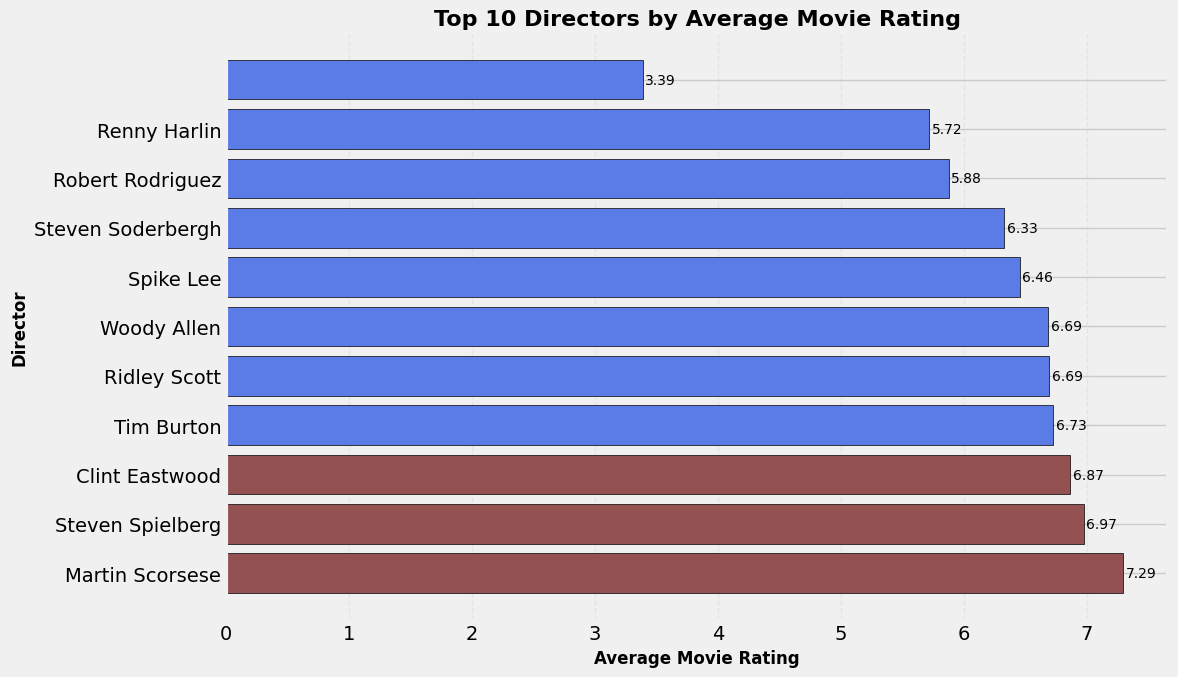

In [28]:
top_directors = data_after_json['director'].value_counts().head(11).index

director_avg = (
    data_after_json[data_after_json['director'].isin(top_directors)]
    .groupby('director')['vote_average']
    .mean()
    .sort_values()
)

colors = ["#945151" if i > 7 else '#5b7be6' if i >= len(director_avg)-2 else '#5b7be6' 
          for i in range(len(director_avg))]

plt.figure(figsize=(12, 7), facecolor='#f0f0f0')

bars = plt.barh(director_avg.index, director_avg.values,
                color=colors, edgecolor='black')

plt.gca().invert_yaxis()

for bar in bars:
    plt.text(bar.get_width() + 0.02,
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}",
             va='center', fontsize=10)

plt.xlabel('Average Movie Rating', fontsize=12, fontweight='bold')
plt.ylabel('Director', fontsize=12, fontweight='bold')
plt.title('Top 10 Directors by Average Movie Rating', fontsize=16, fontweight='bold')

plt.yticks(rotation=0, ha='right')
plt.subplots_adjust(left=0.3)

plt.gca().set_facecolor('#f0f0f0')
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/Top10_Directors_by_Movie_Rating.png', dpi=300, bbox_inches='tight')
plt.show()

This chart shows the Top 10 Directors ranked by their average movie ratings, revealing a clear quality hierarchy among filmmakers in the dataset. Martin Scorsese dominates with a 7.29 average, followed by Steven Spielberg (6.97) and Clint Eastwood (6.87), who are visually separated with red bars to indicate elite-tier performance above the 6.8 threshold. The remaining seven directors cluster tightly between 5.39-6.73, with Tim Burton, Ridley Scott, and Woody Allen leading this mid-tier group. There's a notable 0.32-point gap between Scorsese and Spielberg, the largest separation in the chart, emphasizing Scorsese's exceptional consistency. The relatively narrow overall range (5.39-7.29) suggests these are all established directors with proven track records rather than a mix of acclaimed and poor filmmakers.

For the recommendation models, this analysis validates director as a valuable content feature since there's measurable quality differentiation between filmmakers. Models can leverage this by weighting director similarity higher in the TF-IDF vectorization or creating a separate "director_tier" categorical feature (Elite/High/Standard) to improve matching accuracy. Films by top-tier directors (>6.8 rating) could be prioritized for users who demonstrate preferences for critically acclaimed content, while the tight clustering in the 6.3-6.8 range represents a "safe recommendation zone" for general audiences. This insight directly informs feature engineering decisions—director name should be included in the content "soup" and potentially given higher importance weights compared to less predictive features.

### Section IV - Relationships & Correlations 

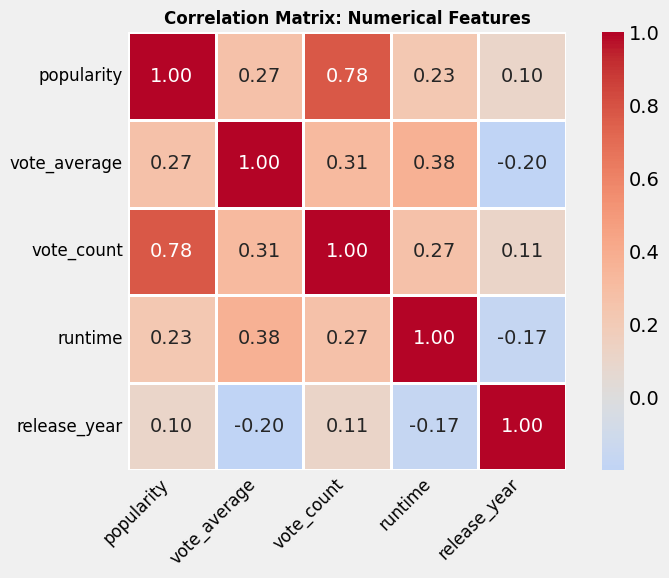

In [29]:
numerical_cols = ['popularity', 'vote_average', 'vote_count', 'runtime', 'release_year']
correlation = data_after_json[numerical_cols].corr()

plt.figure(figsize=(8,6))

sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Matrix: Numerical Features', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('../images/Correlation_Matrix_Numerical_Features.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap titled "Correlation Matrix: Numerical Features" visualizes pairwise correlations among five quantitative variables: popularity, vote_average, vote_count, runtime, and release_year. Color intensity encodes correlation strength, from blue (negative) to red (positive), with the diagonal showing perfect self-correlation (1.0).

Popularity and vote_count are strongly correlated (0.78), indicating that highly popular films receive more votes. Runtime shows a moderate positive correlation with vote_average (0.38), suggesting longer films tend to be rated slightly higher. Release_year exhibits weak negative correlations with vote_average (-0.20) and runtime (-0.17), implying newer films are slightly shorter and less well-rated. Other relationships, such as popularity vs. release_year (0.10), are negligible.

This matrix highlights that user engagement (vote count) is the dominant driver of popularity, providing a clear signal for feature selection in modeling.

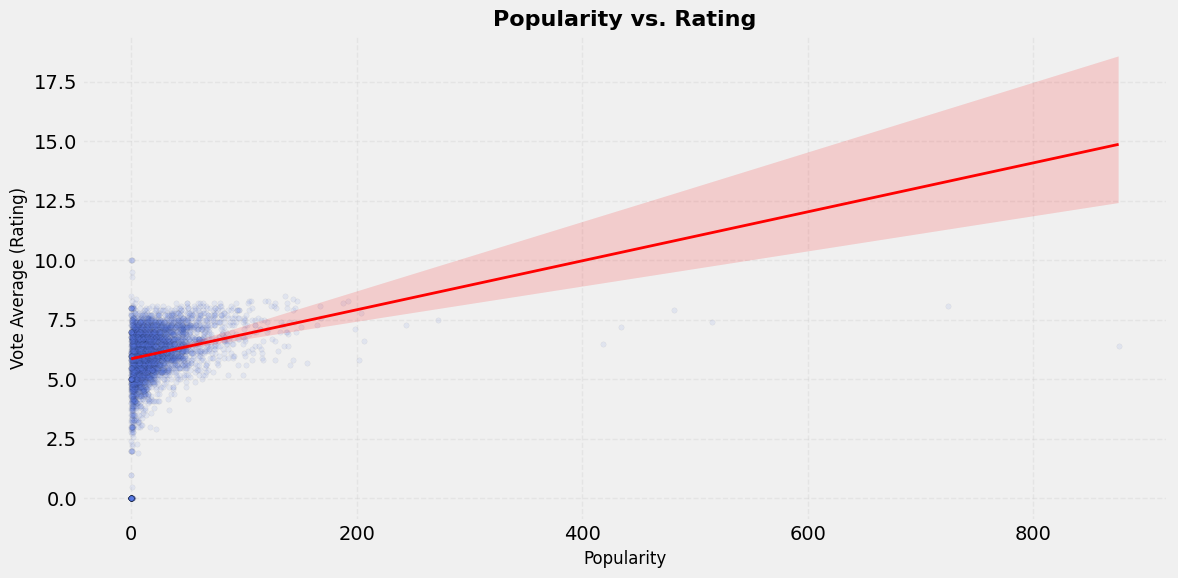

In [30]:
plt.figure(figsize=(12, 6), facecolor='#f0f0f0')

# Scatter plot
plt.scatter(data_after_json['popularity'], data_after_json['vote_average'],
            alpha=0.1, s=15, color='#5b7be6', edgecolor='black', linewidth=0.2)

# Regression line
sns.regplot(x='popularity', y='vote_average', data=data_after_json, 
            scatter=False, color='red', line_kws={'linewidth': 2})

plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Vote Average (Rating)', fontsize=12)
plt.title('Popularity vs. Rating', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../images/Popularity_vs_Rating.png', dpi=300, bbox_inches='tight')
plt.show()

The scatter plot reveals a weak positive correlation (r≈0.3) between popularity and rating, proving that popular movies aren't always good. Most films concentrate in the low-popularity region (<100) with moderate ratings (5.5-7.5), while high-popularity films show increasing rating variance - they're more polarizing.

We identified two critical patterns: "overhyped blockbusters" (popularity >400, rating <6) representing commercial successes that disappointed audiences, and "hidden gems" (popularity <50, rating >7.5) - quality films with low visibility. These outliers significantly impact recommendation strategy.

To address this, our recommender uses a weighted hybrid score (60% quality + 40% popularity) instead of pure content similarity. We filter out overhyped disappointments (popularity >300 AND rating <6) and boost hidden gems through a quality-to-hype ratio feature. This ensures recommendations balance mainstream appeal with actual quality, preventing the system from only suggesting blockbusters while surfacing underrated excellent films.

### Section V - Language & Production

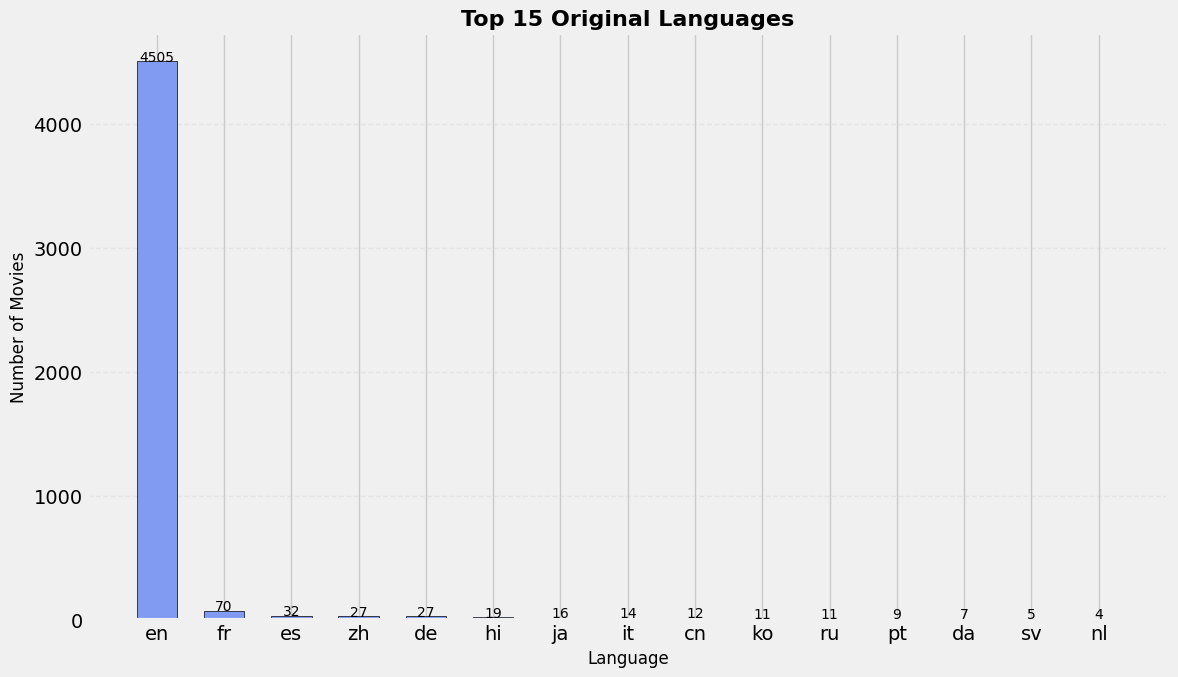

In [31]:
plt.figure(figsize=(12, 7), facecolor='#f0f0f0')

language_counts = data_after_json['original_language'].value_counts().head(15)

bars = plt.bar(language_counts.index, language_counts.values,
               color="#819bf3", edgecolor='black', width=0.6)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             int(bar.get_height()), ha='center', fontsize=10)

plt.xlabel('Language', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Top 15 Original Languages', fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().set_facecolor("#f0f0f0")

plt.tight_layout()
plt.savefig('../images/Top15_Original_Languages.png', dpi=300, bbox_inches='tight')
plt.show()

The dataset shows severe English dominance (about 94%), with French (0.14%), Spanish (0.007%), and German (0.006%)  as distant runners-up. This Anglocentric bias means the recommender will naturally favor Hollywood  productions due to sample size advantages. Non-English films, especially Asian cinema, are significantly  underrepresented.

Impact on Model: We will add language filtering options in the app and apply same-language boosting 
(+0.1 similarity score) for non-English inputs to improve international film discovery. However, 
recommendation quality for languages outside the top 5 remains limited by small sample sizes - a 
known dataset limitation.

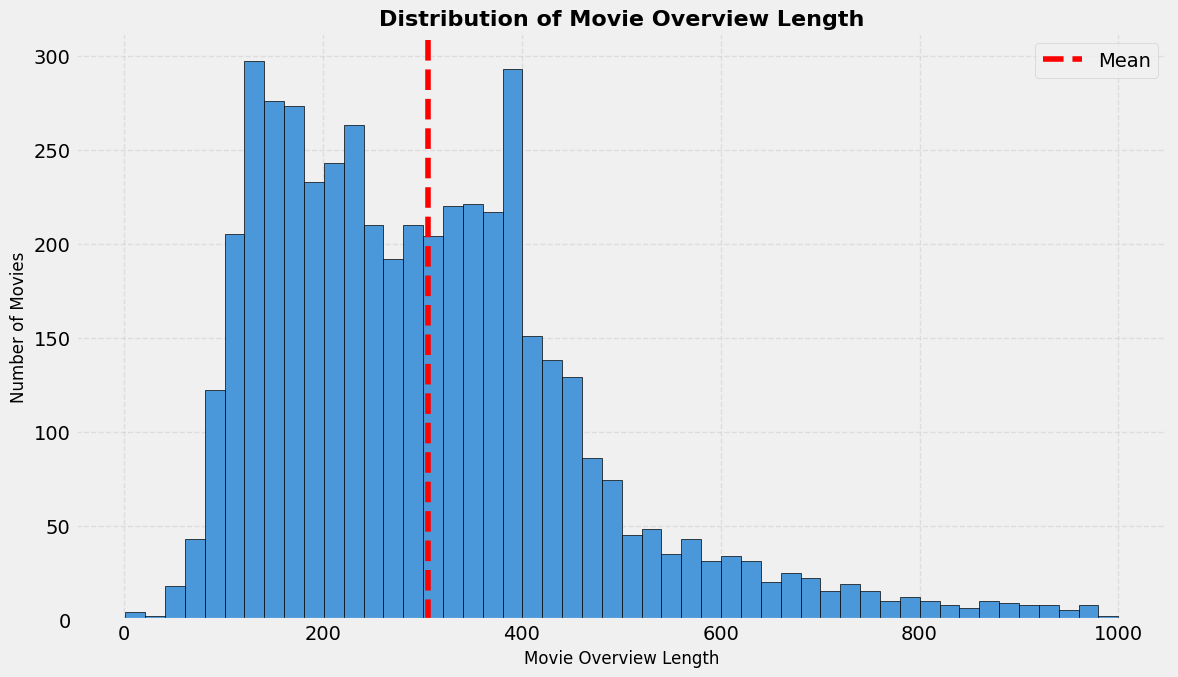

In [32]:
plt.figure(figsize=(12, 7), facecolor='#f0f0f0')

data_after_json['overview_length'] = data_after_json['overview'].fillna('').str.len()
data_after_json['overview_length'].hist(bins=50, edgecolor='black', color="#4a97da")
plt.axvline(data_after_json['overview_length'].mean(), color='red', linestyle='--', label='Mean')

plt.xlabel('Movie Overview Length', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.title('Distribution of Movie Overview Length', fontsize=16, weight='bold')

plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor("#f0f0f0")

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../images/Distribution_of_Movie_Overview_Length.png', dpi=300, bbox_inches='tight')
plt.show()

The distribution of movie overview lengths is right-skewed, with the majority (~65%) of overviews ranging from 150–400 characters and peaking around 175–200 characters. The mean overview length is approximately 275 characters, with a long tail extending beyond 1,000 characters, reflecting detailed descriptions of complex narratives or foreign films requiring additional context.

This variability supports the choice of TF-IDF vectorization over simple count-based approaches, as TF-IDF normalizes for document length and prevents longer overviews from dominating similarity calculations. All overviews are retained (except completely empty ones), since TF-IDF's cosine similarity is length-invariant and even brief descriptions (~100 characters) contain informative keyword signals.

For the small subset of movies with very short overviews (<100 characters), adaptive feature weighting is applied by increasing the influence of structured metadata (e.g., keywords, genres). This ensures that recommendation quality remains consistent across the dataset, regardless of overview length.

## Feature engineering

In [33]:
#Cleaning function - small letters, erasing spaces

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ""

features = ['cast', 'keywords', 'director', 'genres']
for feature in features:
    data_after_json[feature] = data_after_json[feature].apply(clean_data)

To avoid niche movies with very few votes appearing unrealistically high in rankings, we use a Weighted Rating (WR) formula:

$$\text{Weighted Rating (WR)} = \left( \frac{v}{v+m} \cdot R \right) + \left( \frac{m}{v+m} \cdot C \right)$$

where:

- R = average rating of the movie

- v = number of votes for the movie

- C = mean rating across all movies

- m = minimum number of votes required to be listed

This formula adjusts a movie’s rating toward the global average when it has few votes. As the number of votes increases, the movie’s own rating has more influence.

In this way, the weighted rating promotes movies that have both a high rating and a large number of votes, while preventing little-known films with only a few ratings from dominating the rankings.

In [34]:
C = data_after_json['vote_average'].mean()
m = data_after_json['vote_count'].quantile(0.60)

def WR(x, m=m, C=C):
    R = x['vote_average']
    v = x['vote_count']
    return (v / (v + m) * R) + (m / (v + m) * C)

data_after_json['weighted_rating'] = data_after_json.apply(WR, axis=1)

As illustrated in the charts above, popularity and vote count follow long-tailed distributions; therefore, logarithmic scaling is applied to reduce skewness and stabilize the data.

In [35]:
data_after_json['log_vote_count'] = np.log1p(data_after_json['vote_count'])

data_after_json['log_popularity'] = np.log1p(data_after_json['popularity'])

As noted in the description below the chart, movies with a runtime of less than 15 minutes are treated as erroneous entries and are replaced with the median runtime value.

In [36]:
data_after_json.loc[data_after_json['runtime'] <= 15, 'runtime'] = np.nan

data_after_json['runtime'] = data_after_json['runtime'].fillna(data_after_json['runtime'].median())

As indicated by the chart of movies by release year, the model may be biased toward newer films; thus, we convert the release year into movie age and subsequently apply feature scaling.

In [37]:
current_year = datetime.now().year

data_after_json['movie_age'] = current_year = data_after_json['release_year']

data_after_json['log_movie_age'] = np.log1p(data_after_json['movie_age'])

As the popularity vs. rating chart suggests, some movies require careful consideration. There are blockbusters that performed well commercially but received low viewer ratings, and hidden gems that were less popular but rated highly.

As mentioned in the description, we define the quality score as a weighted combination:

$$quality score = 0.6 × rating + 0.4 × popularity$$

In [38]:
scaler = MinMaxScaler()

data_after_json[['popularity_scaled', 'vote_average_scaled']] = scaler.fit_transform(
    data_after_json[['popularity', 'vote_average']]
)

data_after_json['hybrid_score'] = (
    0.6 * data_after_json['vote_average_scaled'] +
    0.4 * data_after_json['popularity_scaled']
)

## Model Building and Evaluation

### First Model - Demographic Filtering (Baseline)

The primary objective of the model is to generate a global Top-Movies ranking — a universal list of the best movies that is identical for all users and does not rely on personal preferences.

Instead of using raw average ratings, the system applies a weighted rating formulation to ensure both quality and statistical reliability. This prevents movies with only a few extreme ratings (e.g., a single 10/10 vote) from incorrectly appearing at the top of the ranking.

In [39]:
def calculate_weighted_rating(df, percentile=0.90):
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    df['weighted_rating'] = df.apply(
        lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + 
                  (m/(x['vote_count']+m) * C),
        axis=1
    )
    
    return df, C, m

data_after_json, C, m = calculate_weighted_rating(data_after_json)


In [40]:
def get_baseline_recommendations(df, n=10, min_votes=None, genre_filter=None):
    if min_votes is None:
        min_votes = m
    
    filtered_df = df[df['vote_count'] >= min_votes].copy()
    
    if genre_filter:
        filtered_df = filtered_df[
            filtered_df['genres'].apply(lambda x: genre_filter in x)
        ]
    
    top_n = filtered_df.sort_values('weighted_rating', ascending=False).head(n)
    return top_n

global_top_10 = get_baseline_recommendations(data_after_json, n=10)

display(global_top_10[['original_title','release_year','vote_average','vote_count','weighted_rating']])

,original_title,release_year,vote_average,vote_count,weighted_rating
127,The Shawshank Redemption,1994,8.5,8205,8.059258
230,Fight Club,1999,8.3,9413,7.939256
68,The Dark Knight,2008,8.2,12002,7.920020
305,Pulp Fiction,1994,8.3,8428,7.904645
2955,Inception,2010,8.1,13752,7.863239
110,The Godfather,1972,8.4,5893,7.851236
4170,Interstellar,2014,8.1,10867,7.809479
3,Forrest Gump,1994,8.2,7927,7.803188
56,The Lord of the Rings: The Return of the King,2003,8.1,8064,7.727243
602,The Empire Strikes Back,1980,8.2,5879,7.697884


In [41]:
#Metrics for base model

def evaluate_baseline_model(df, top_n_movies):
    metrics = {}
    
    # Average Rating / Votes / Weighted
    metrics['avg_rating'] = top_n_movies['vote_average'].mean()
    metrics['avg_vote_count'] = top_n_movies['vote_count'].mean()
    metrics['avg_weighted_rating'] = top_n_movies['weighted_rating'].mean()
    
    # Genre Diversity
    all_genres = [g for genres in top_n_movies['genres'] for g in genres]
    metrics['genre_diversity'] = len(set(all_genres))
    metrics['most_common_genre'] = Counter(all_genres).most_common(1)[0]
    
    # Year Stats
    metrics['year_std'] = top_n_movies['release_year'].std()
    metrics['avg_year'] = top_n_movies['release_year'].mean()
    metrics['oldest_movie'] = top_n_movies['release_year'].min()
    metrics['newest_movie'] = top_n_movies['release_year'].max()
    
    # Coverage & Popularity Bias
    metrics['coverage'] = len(top_n_movies) / len(df) * 100
    metrics['popularity_bias'] = top_n_movies['vote_count'].mean() / df['vote_count'].mean()
    
    return metrics

baseline_metrics = evaluate_baseline_model(data_after_json, global_top_10)

for k, v in baseline_metrics.items():
    if isinstance(v, float):
        print(f"{k.replace('_',' ').title():25}: {v:.2f}")
    elif isinstance(v, tuple):
        print(f"{k.replace('_',' ').title():25}: {v[0]} ({v[1]} movies)")
    else:
        print(f"{k.replace('_',' ').title():25}: {v}")

Avg Rating               : 8.24
Avg Vote Count           : 9043.00
Avg Weighted Rating      : 7.86
Genre Diversity          : 10
Most Common Genre        : drama (6 movies)
Year Std                 : 13.16
Avg Year                 : 1996.80
Oldest Movie             : 1972
Newest Movie             : 2014
Coverage                 : 0.21
Popularity Bias          : 13.10


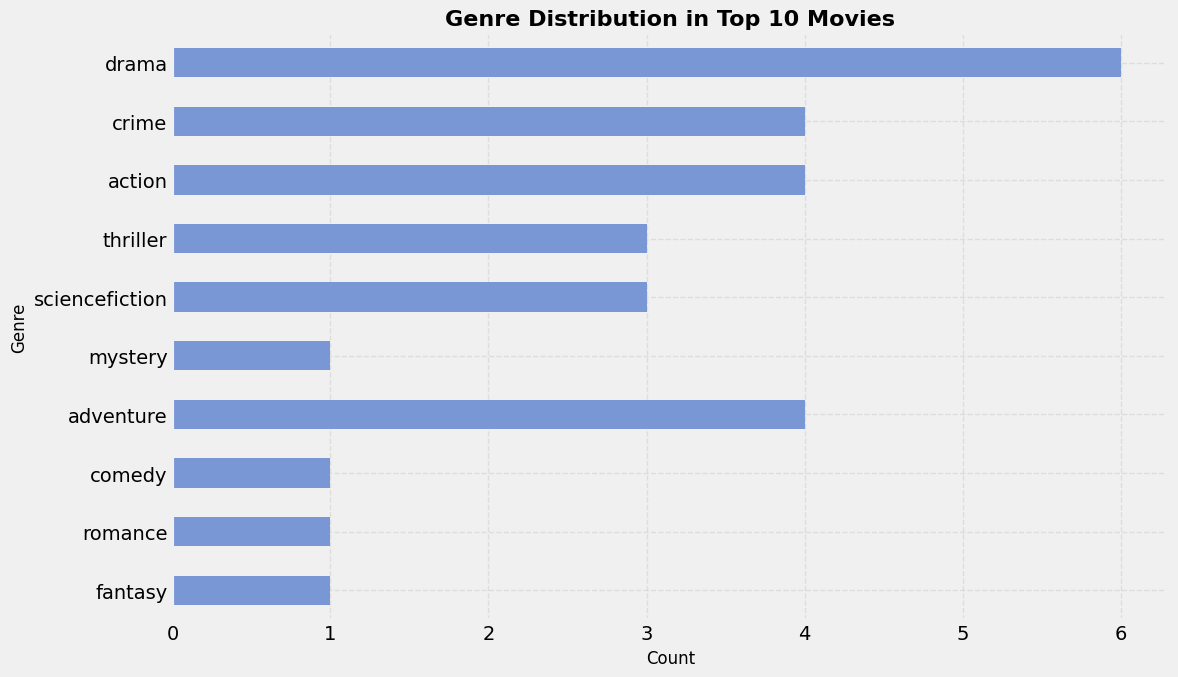

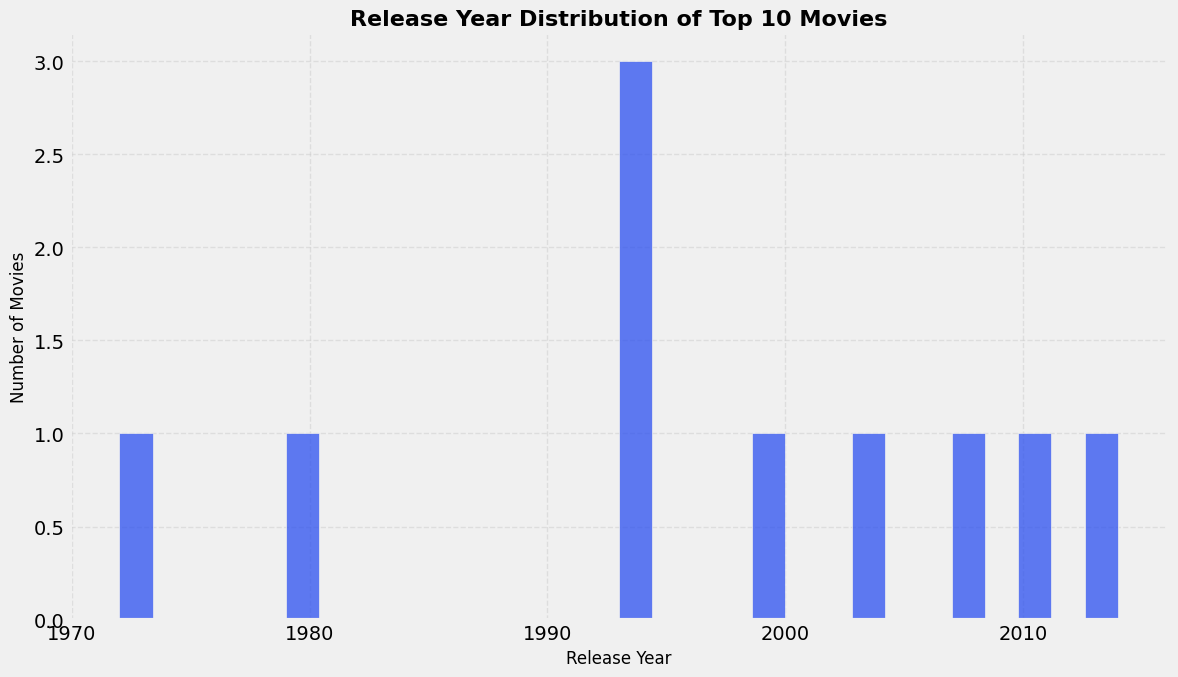

In [42]:
#Genre Distribution

top_genres = [g for genres in global_top_10['genres'] for g in genres]
genre_counts = Counter(top_genres)

plt.figure(figsize=(12,7), facecolor='#f0f0f0')
sns.barplot(x=list(genre_counts.values()), y=list(genre_counts.keys()), color="#6a91e4", width=0.5)
plt.title('Genre Distribution in Top 10 Movies', fontsize=16, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/Genre_Distribution_in_Top10_Movies.png', dpi=300, bbox_inches='tight')
plt.show()

#Release Year Distribution

plt.figure(figsize=(12,7))
sns.histplot(global_top_10['release_year'], bins=30, kde=False, color="#2C50F0")
plt.title('Release Year Distribution of Top 10 Movies', fontsize=16, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/Release_Year_Distribution_of_Top_10_Movies.png', dpi=300, bbox_inches='tight')
plt.show()


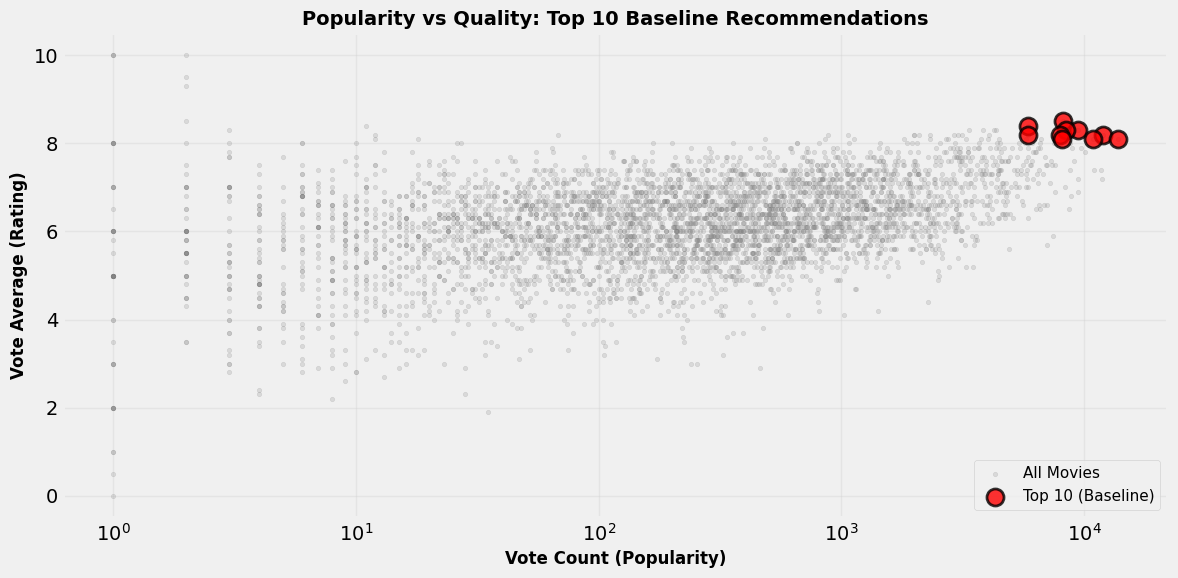

In [43]:
plt.figure(figsize=(12, 6))

# All movies (background)
plt.scatter(
    data_after_json['vote_count'], 
    data_after_json['vote_average'],
    alpha=0.2, s=10, c='gray', label='All Movies'
)

# Top 10 (highlighted)
plt.scatter(
    global_top_10['vote_count'],
    global_top_10['vote_average'],
    alpha=0.8, s=150, c='red', edgecolor='black', 
    linewidth=2, label='Top 10 (Baseline)', zorder=5
)

plt.xlabel('Vote Count (Popularity)', fontsize=12, weight='bold')
plt.ylabel('Vote Average (Rating)', fontsize=12, weight='bold')
plt.title('Popularity vs Quality: Top 10 Baseline Recommendations', 
          fontsize=14, weight='bold')
plt.xscale('log')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/Popularity_vs_Quality_Top10_Baseline_Recommendations.png', dpi=300, bbox_inches='tight')
plt.show()


### Second Model - Intelligent Rocommendations System

In [44]:
#Soup - joining names in one string

all_genres = [g for genres in data_after_json['genres'] for g in genres]
genre_counts = Counter(all_genres)
total_movies = len(data_after_json)

genre_weights = {
    genre: np.log(total_movies / count)
    for genre, count in genre_counts.items()
}

def cooking_soup_weighted(x):
    soup_string = ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' '.join(x['genres']) + ' ' + x['overview']
    
    # Weighted genres
    for genre in x['genres']:
        weight = genre_weights.get(genre, 1.0)
        repeats = max(1, int(weight))
        soup_string += f" {genre.lower()}" * repeats + ' '
    
    return soup_string

data_after_json['soup'] = data_after_json.apply(cooking_soup_weighted, axis=1)

In [45]:
#Using TF-IDF and CountVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data_after_json['overview'])

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data_after_json['soup'])

combined_matrix = normalize(hstack([tfidf_matrix, count_matrix]))

#Matrix similarity

cosine_sim = cosine_similarity(combined_matrix)

In [46]:
#Recommendation function

indices = pd.Series(data_after_json.index, index=data_after_json['original_title']).drop_duplicates()

def recommendation(title, cosine_similarity, data_after_json, alpha=0.5):
    if title not in indices:
        return f"Film {title} was not found in the database"
    
    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    similarity_scores = list(enumerate(cosine_similarity[idx]))
    similarity_scores = sorted(similarity_scores, key = lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:51]

    movie_indices = [i[0] for i in similarity_scores]
    similarity_values = [i[1] for i in similarity_scores]
    
    candidates = data_after_json.iloc[movie_indices].copy()
    candidates['similarity'] = similarity_values

    def normalize(series):
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series.apply(lambda x: 0.5) 
        return (series - min_val) / (max_val - min_val)

    candidates['similarity_norm'] = normalize(candidates['similarity'])
    candidates['quality_norm'] = normalize(candidates['hybrid_score']) 
    
    candidates['final_score'] = (alpha * candidates['quality_norm']) + ((1-alpha) * candidates['similarity_norm'])

    candidates = candidates.sort_values('final_score', ascending=False)

    return candidates[['original_title','movie_age','vote_average',
                   'hybrid_score','similarity','final_score',
                   'genres','vote_count']].reset_index()


In [47]:
def evaluate_content_based_recommender(data, cosine_sim, sample_size=50, top_k=10, plot_charts=False):
    metrics_results = {
        'input_movie': [],
        'genre_overlap': [],
        'avg_similarity': [],     
        'quality': [],
        'diversity': [],
        'popularity_bias': [],
        'input_genres': [],       
        'input_rating': []        
    }
    
    safe_sample_size = min(sample_size, len(data))
    sample_indices = random.sample(list(data.index), safe_sample_size)
    
    dataset_avg_votes = data['vote_count'].mean()
    
    for idx in sample_indices:
        input_movie = data.iloc[idx]
        
        recs = recommendation(input_movie['original_title'], cosine_sim, data, alpha=0.5)
        rec_indices = recs['index'].values[:top_k]
        recs = data.loc[rec_indices]

        metrics_results['input_movie'].append(input_movie['original_title'])
        metrics_results['input_genres'].append(input_movie['genres'])
        metrics_results['input_rating'].append(input_movie['vote_average'])
        
        input_genres = set(input_movie['genres'])
        
        overlaps = []
        for rec_idx in rec_indices:
            rec_genres = set(data.iloc[rec_idx]['genres'])
            
            if len(input_genres | rec_genres) > 0:
                overlap = len(input_genres & rec_genres) / len(input_genres | rec_genres)
            else:
                overlap = 0
            
            overlaps.append(overlap)
        
        genre_overlap_score = np.mean(overlaps)
        metrics_results['genre_overlap'].append(genre_overlap_score)
        
        recs_with_scores = recommendation(input_movie['original_title'], cosine_sim, data, alpha=0.5)

        similarities = recs_with_scores['similarity'].values[:top_k]
        avg_sim = np.mean(similarities)
        metrics_results['avg_similarity'].append(avg_sim)
        
        quality_score = recs['vote_average'].mean()
        metrics_results['quality'].append(quality_score)
        
        if len(rec_indices) > 1:
            pairs = list(itertools.combinations(rec_indices, 2))
            pair_similarities = [cosine_sim[p[0]][p[1]] for p in pairs]

            pair_similarities = np.clip(pair_similarities, 0, 1)

            diversity_score = 1 - np.mean(pair_similarities)
        else:
            diversity_score = 0
        
        metrics_results['diversity'].append(diversity_score)
        
        avg_votes = recs['vote_count'].mean()
        popularity_bias = avg_votes / dataset_avg_votes
        metrics_results['popularity_bias'].append(popularity_bias)
    
    metrics_df = pd.DataFrame(metrics_results)
    
    return metrics_df

In [50]:
def run_simulation_no_plots(iterations=20, sample_size=50):
    all_results = []

    for i in range(iterations):
        df = evaluate_content_based_recommender(
            data_after_json, 
            cosine_sim, 
            sample_size=sample_size, 
            top_k=10, 
            plot_charts=False  
        )
        df['iteration'] = i
        all_results.append(df)
        
    global_df = pd.concat(all_results, ignore_index=True)
    return global_df

global_results = run_simulation_no_plots(iterations=20, sample_size=50)

print("\n📊 AVERAGE RESULTS FROM SIMULATION:")
print(global_results[['quality', 'diversity', 'genre_overlap', 'popularity_bias']].mean())


📊 AVERAGE RESULTS FROM SIMULATION:
quality            6.567320
diversity          0.712120
genre_overlap      0.649826
popularity_bias    1.450640
dtype: float64


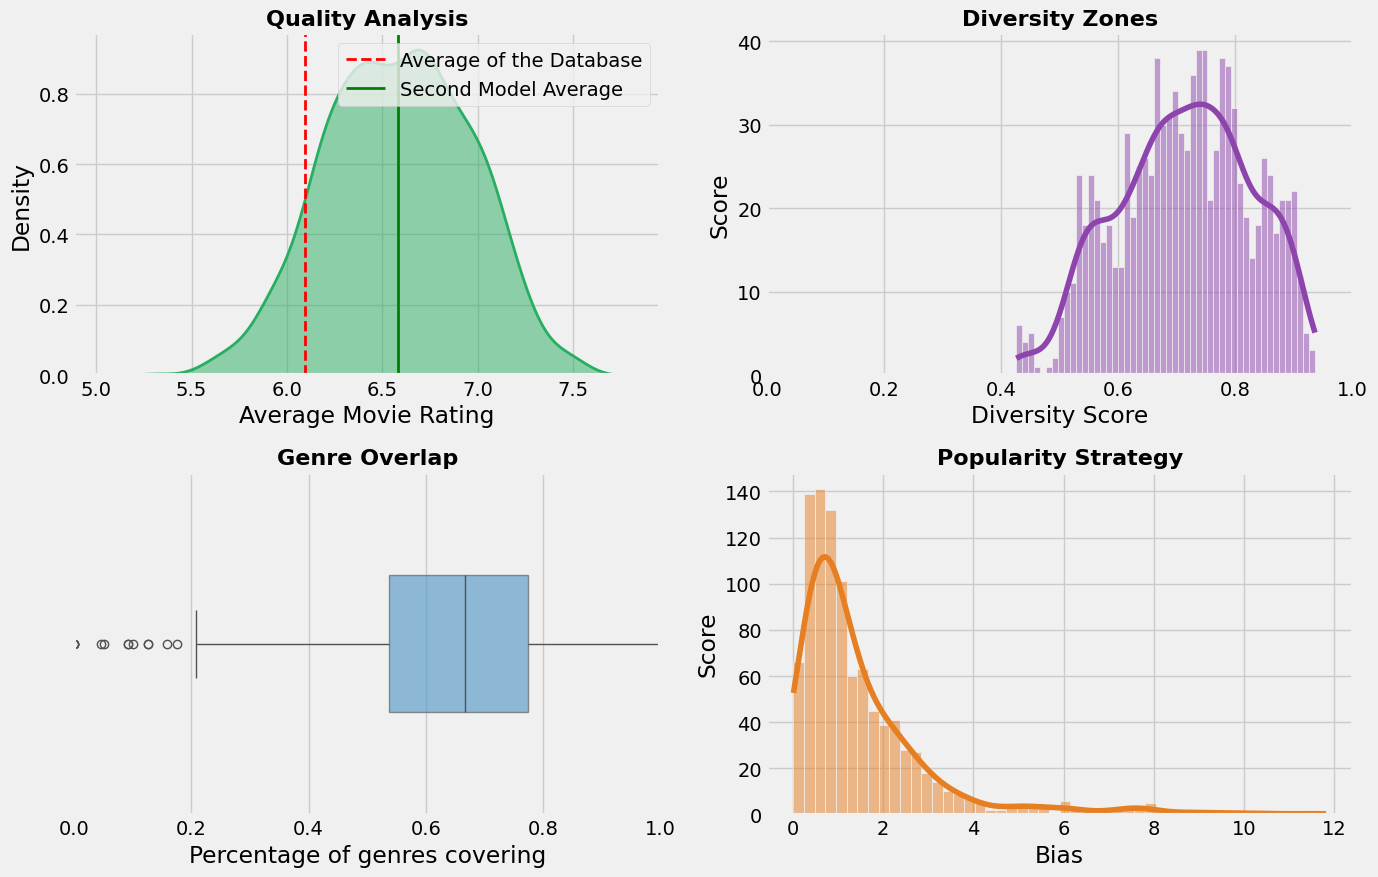

In [49]:
def plot_results(results_df, full_data):
    fig, ax = plt.subplots(2, 2, figsize=(14, 9), facecolor='#f0f0f0')
    average_quality = full_data['vote_average'].mean()

    #First plot - Quality (density plot)
    ax1 = ax[0, 0]
    sns.kdeplot(data=results_df, x='quality', fill=True, color='#27ae60', alpha=0.5, linewidth=2, ax=ax1)
    ax1.axvline(average_quality, color='red', linestyle='--', linewidth=2, label='Average of the Database')
    ax1.axvline(results_df['quality'].mean(), color='green', linestyle='-', linewidth=2, label='Second Model Average')

    ax1.set_title('Quality Analysis', fontsize=16, weight='bold')
    ax1.set_xlabel('Average Movie Rating')
    ax1.legend(loc='upper right')
    plt.tight_layout()

    #Second plot - Diversity (histogram)
    ax2 = ax[0, 1]
    sns.histplot(data=results_df, x='diversity', kde=True, color='#8e44ad', ax=ax2, bins=50)

    ax2.set_title('Diversity Zones', fontsize=16, weight='bold')
    ax2.set_xlabel('Diversity Score')
    ax2.set_ylabel('Score')
    ax2.set_xlim(0, 1)
    plt.tight_layout()

    #Third plot - Genre Overlap (Boxplot)
    ax3=ax[1, 0]
    sns.boxplot(x=results_df['genre_overlap'], ax=ax3, color='#3498db', width=0.4, boxprops=dict(alpha=0.6))

    ax3.set_title('Genre Overlap', fontsize=16, weight='bold')
    ax3.set_xlabel('Percentage of genres covering')
    ax3.set_xlim(0, 1)
    plt.tight_layout()

    #Fourth plot - Popularity Bias (histogram)
    ax4=ax[1, 1]
    sns.histplot(data=results_df, x='popularity_bias', kde=True, color='#e67e22', bins=50)

    ax4.set_title('Popularity Strategy', fontsize=16, weight='bold')
    ax4.set_xlabel('Bias')
    ax4.set_ylabel('Score')

    plt.tight_layout()
    plt.savefig('../images/Plot_Results_for_Second_Model.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_results(global_results, data_after_json)

### Saving Model

In [58]:
columns_to_keep = [
    'original_title', 
    'movie_age',        
    'vote_average', 
    'vote_count',
    'genres', 
    'hybrid_score'
]

data_for_app = data_after_json[columns_to_keep].copy()

model_data = {
    'dataframe': data_for_app,
    'similarity': cosine_sim,
    'indices': indices
}

with open('../models/recommendation_model.joblib', 'wb') as f:
    joblib.dump(model_data, f)

### Models Comparision

